Это ноутбук research. Здесь будут вестись все исследования и размышления

In [1]:
%load_ext autoreload
%autoreload 2

# План

1) Получить и обработать данные временного ряда
2) Перебрать лаги и собрать z вектора
3) Кластеризовать z вектора внутри одного паттерна, отобрать мотивы
4) Предскзание
    1. Пройтись по паттернам
    2. Найти ближайшие вектора / центры кластеров
    3. Берем у таких векторов последние значение и усредняем / медиана
    4. Если большая дисперсия или мало векторов -> Non-predictable
    5. Финальный ответ - среднее (взвешанное) по паттернам

# Кластеризация

Нужно реализовать модифицированный алгоритм кластеризации Уишарта. Для подбора гиперпараметров буду испольвать метрики оценки качества кластеризации силуэт скор, Халински-Карабах индекс, Дэвиc-Болдуин индекс.  



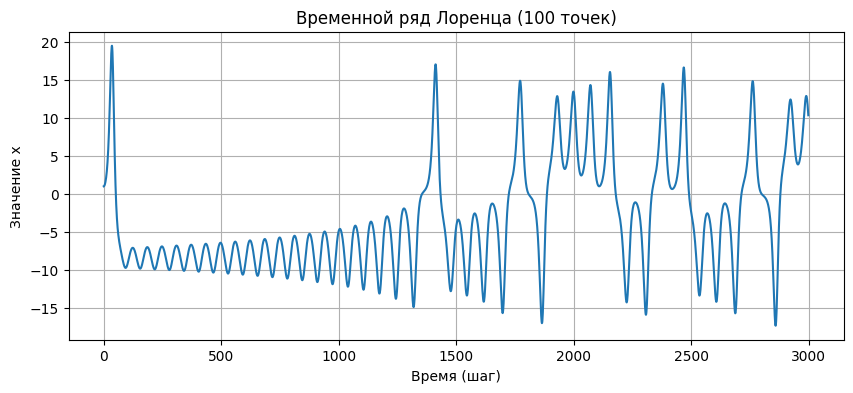

In [2]:
from utils import *
import matplotlib.pyplot as plt

lorenz_series = generate_lorenz_series(n_points=3000)

# Визуализируем временной ряд
plt.figure(figsize=(10, 4))
plt.plot(lorenz_series)
plt.title("Временной ряд Лоренца (100 точек)")
plt.xlabel("Время (шаг)")
plt.ylabel("Значение x")
plt.grid(True)
plt.show()

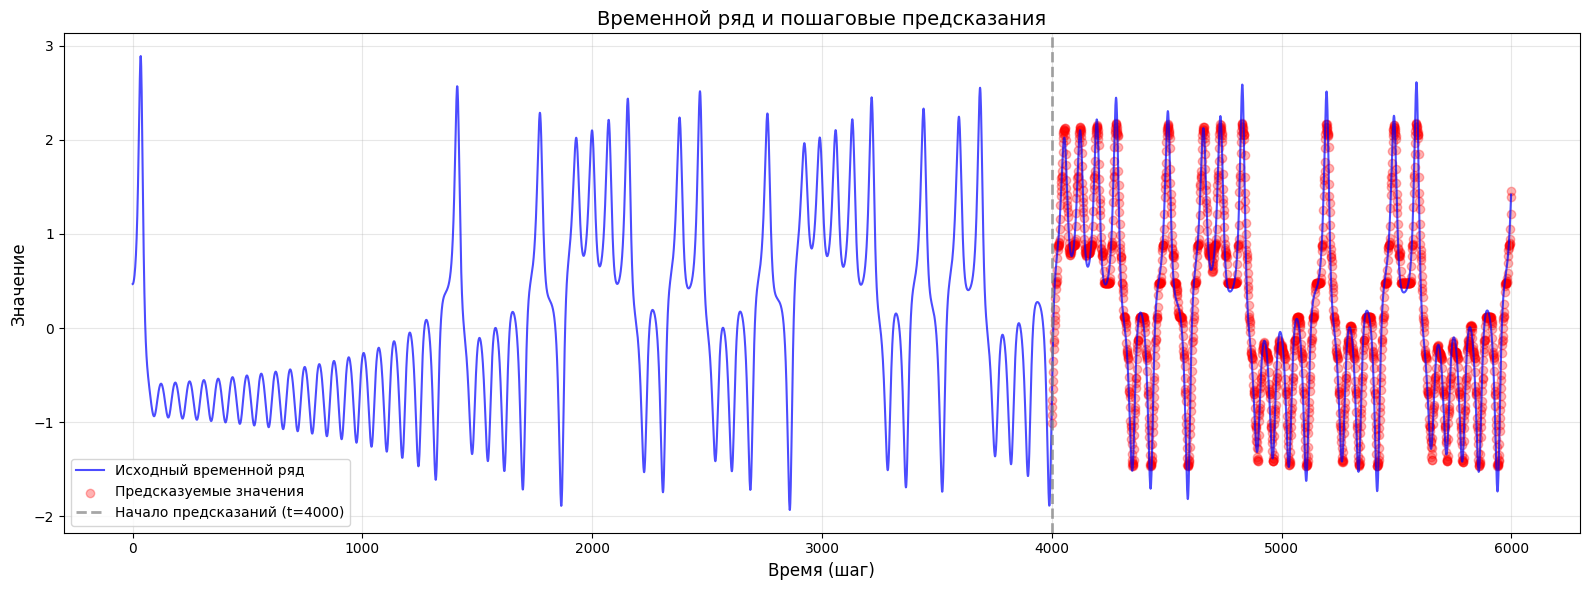

Сгенерировано предсказаний: 2000
MSE: 0.024840


In [ ]:
from utils import generate_lorenz_series, generate_patterns, zscore_normalize
from clustering import KMeansPatternClustering
from prediction import MultiPatternPredictor
import matplotlib.pyplot as plt
import numpy as np

# генерация данных
series = generate_lorenz_series(n_points=6000)

# паттерны
patterns = generate_patterns(pattern_length=4, max_offset=10)

# модель
predictor = MultiPatternPredictor(
    patterns=patterns,
    horizon=1,
    n_clusters=15,
    min_cluster_size=10,
    max_target_std=2.0,
    cluster_method='kmeans'
)

# точка начала предсказаний
prediction_start = 4000
train_series = series[:prediction_start]
train_norm, mu, sigma = zscore_normalize(train_series)
# train_norm, min, max = minmax_normalize(train_series)
test_norm = (series[prediction_start:] - mu) / sigma

# обучение на данных до точки начала предсказаний
predictor.fit(train_norm)

# создаем расширенный ряд для предсказаний
# используем реальные значения до prediction_start, затем предсказания
extended_series = train_norm.copy()
predictions = []
x_pred = []

unpredictable = []
x_unpred = []

# генерируем предсказания пошагово
for i in range(prediction_start, len(series)):
    pred = predictor.predict(extended_series)
    if pred is None:
        unpredictable.append(test_norm[i - prediction_start])
        x_unpred.append(i)
    else:
        predictions.append(pred)
        x_pred.append(i)
    extended_series = np.append(extended_series, test_norm[i - prediction_start])

# визуализация
plt.figure(figsize=(16, 6))

# весь временной ряд
x_full = np.arange(len(series))
plt.plot(x_full, np.append(train_norm, test_norm), 'b-', label='Исходный временной ряд', linewidth=1.5, alpha=0.7)

# часть с предсказаниями
if len(predictions) > 0:
    x_pred = np.array(x_pred)
    plt.scatter(x_pred, predictions, color='r', label='Предсказуемые значения', alpha=0.3, marker='o')

if len(unpredictable) > 0:
    x_unpred = np.array(x_unpred)
    plt.scatter(x_unpred, unpredictable, color='g', label='Непредсказуемые значения', alpha=0.3, marker='o')

# граница обучения/предсказания
plt.axvline(x=prediction_start, color='gray', linestyle='--', linewidth=2, alpha=0.7, label=f'Начало предсказаний (t={prediction_start})')

plt.xlabel('Время (шаг)', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.title('Временной ряд и пошаговые предсказания', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Сгенерировано предсказаний: {len(predictions)}")
if len(predictions) > 0:
    mse = np.mean((predictions - test_norm[x_pred - prediction_start])**2)
    print(f"MSE: {mse:.6f}")


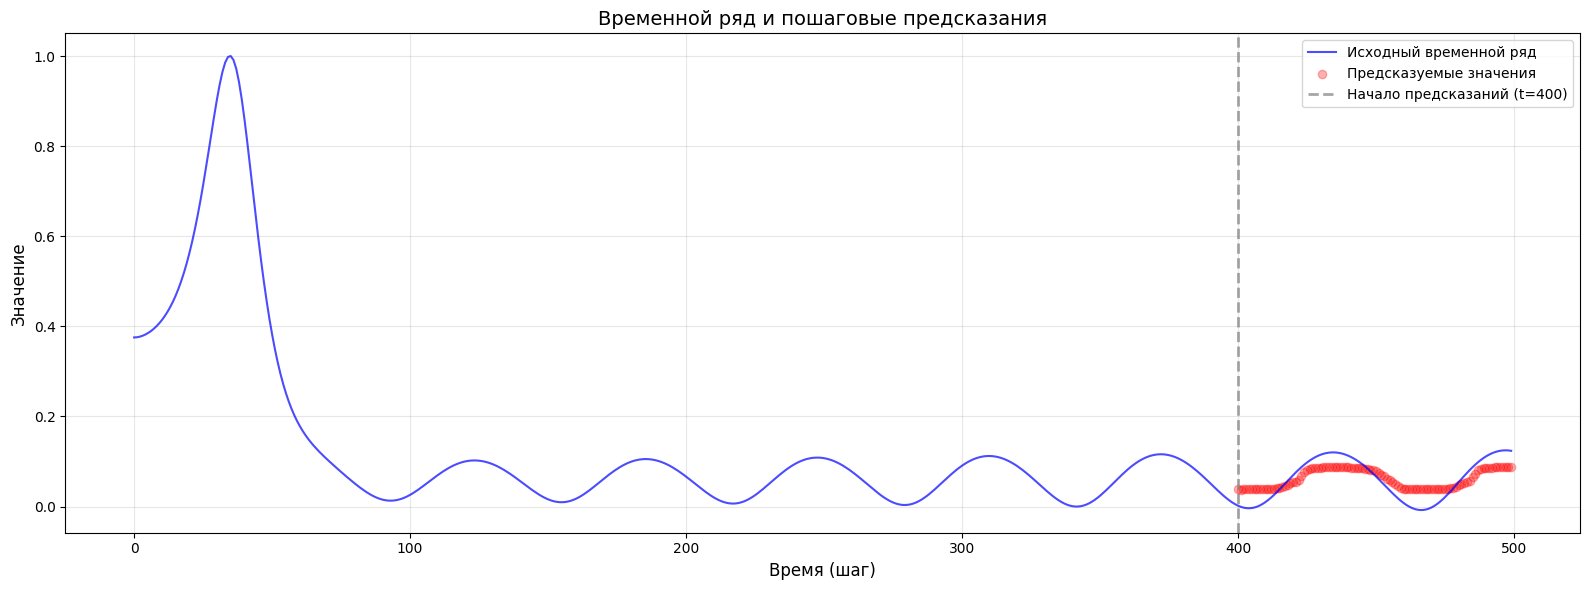

Сгенерировано предсказаний: 100
MSE: 0.000766


In [11]:
from utils import generate_lorenz_series, generate_patterns, zscore_normalize, minmax_normalize
from prediction import MultiPatternPredictor
import matplotlib.pyplot as plt
import numpy as np

# генерация данных
series = generate_lorenz_series(n_points=500)

# паттерны
patterns = generate_patterns(pattern_length=4, max_offset=10)

# модель
predictor = MultiPatternPredictor(
    patterns=patterns,
    horizon=1,
    n_clusters=15,
    min_cluster_size=10,
    max_target_std=2.0, 
    cluster_method='wishart'
)

# точка начала предсказаний
prediction_start = 400
train_series = series[:prediction_start]
# train_norm, mu, sigma = zscore_normalize(train_series)
# test_norm = (series[prediction_start:] - mu) / sigma

train_norm, min, max = minmax_normalize(train_series)
test_norm = (series[prediction_start:] - min) / (max - min)

# обучение на данных до точки начала предсказаний
predictor.fit(train_norm)

# создаем расширенный ряд для предсказаний
# используем реальные значения до prediction_start, затем предсказания
extended_series = train_norm.copy()
predictions = []
x_pred = []

unpredictable = []
x_unpred = []

# генерируем предсказания пошагово
for i in range(prediction_start, len(series)):
    pred = predictor.predict(extended_series)
    if pred is None:
        unpredictable.append(test_norm[i - prediction_start])
        x_unpred.append(i)
    else:
        predictions.append(pred)
        x_pred.append(i)
    extended_series = np.append(extended_series, test_norm[i - prediction_start])

# визуализация
plt.figure(figsize=(16, 6))

# весь временной ряд
x_full = np.arange(len(series))
plt.plot(x_full, np.append(train_norm, test_norm), 'b-', label='Исходный временной ряд', linewidth=1.5, alpha=0.7)

# часть с предсказаниями
if len(predictions) > 0:
    x_pred = np.array(x_pred)
    plt.scatter(x_pred, predictions, color='r', label='Предсказуемые значения', alpha=0.3, marker='o')

if len(unpredictable) > 0:
    x_unpred = np.array(x_unpred)
    plt.scatter(x_unpred, unpredictable, color='g', label='Непредсказуемые значения', alpha=0.3, marker='o')

# граница обучения/предсказания
plt.axvline(x=prediction_start, color='gray', linestyle='--', linewidth=2, alpha=0.7, label=f'Начало предсказаний (t={prediction_start})')

plt.xlabel('Время (шаг)', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.title('Временной ряд и пошаговые предсказания', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Сгенерировано предсказаний: {len(predictions)}")
if len(predictions) > 0:
    mse = np.mean((predictions - test_norm[x_pred - prediction_start])**2)
    print(f"MSE: {mse:.6f}")


Видно что кластеризация Уишарта работает сильно лучше, но появились non-predictable точки

In [6]:
np.where(np.asarray([0, 1, 2, 1, 1]) == 1)[0]

array([1, 3, 4])